## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
from dataclasses import dataclass

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data (no outlier)

In [51]:
data_train = np.load("/kaggle/input/clean-mars/clean/train.npz")
data_test = np.load("/kaggle/input/clean-mars/clean/test.npz")

X_train = data_train["x"]
y_train = data_train["y"]

X_test = data_test["x"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1, 1)


### Outliers removed

In [3]:
X_train_images = np.array([x.reshape(64, 128) for x in X_train])
y_train_masks = np.array([y.reshape(64, 128) for y in y_train])

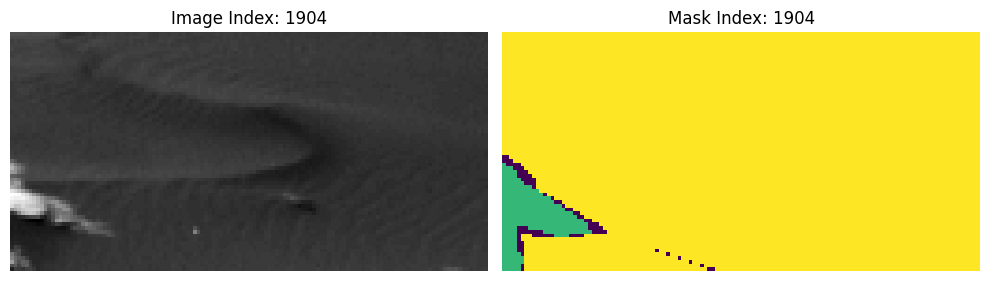

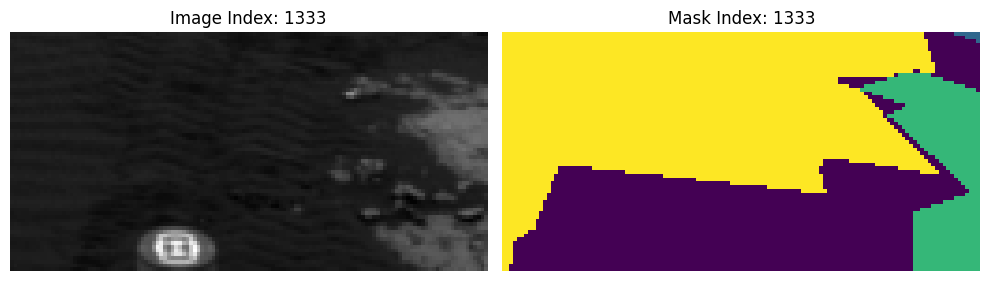

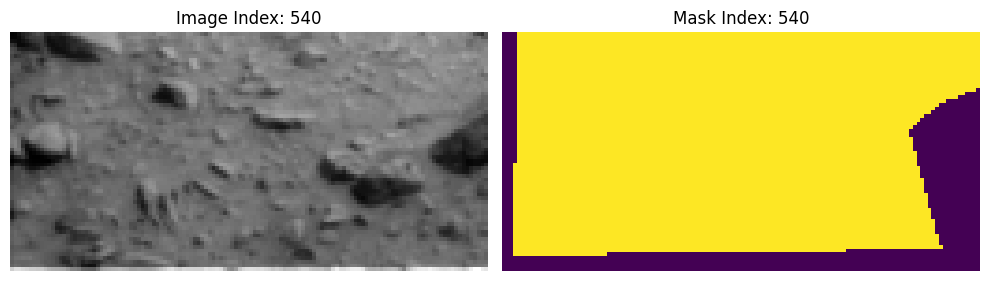

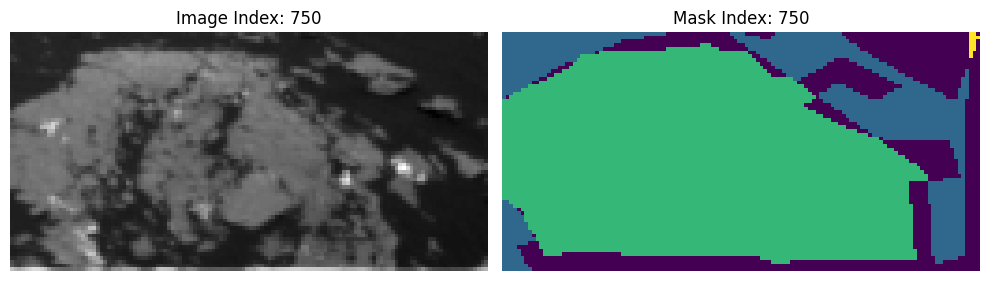

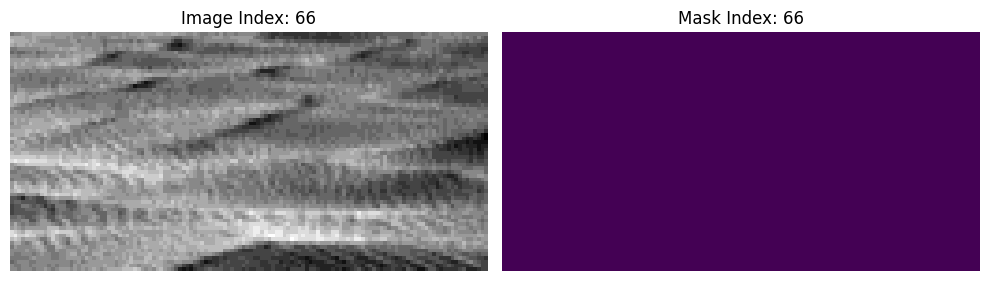

In [4]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## 🛠️ Train and Save the Model

In [26]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1, 1)
Number of classes: 5


In [6]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2505, 64, 128, 1)
y_train shape: (2505, 64, 128)


In [7]:
num_classes

5

In [7]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [8]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (2505, 64, 128, 1)
Shape of y_train after reshaping: (2505, 64, 128, 1)


In [9]:
@dataclass
class Hyperparameters:
    # Model
    activation = "silu"
    # Training
    noise_std: float = 0.05
    optimiser = tfk.optimizers.AdamW
    learning_rate = 1e-5
    regularization1 = tfk.regularizers.L1L2(l1=1e-5, l2=0) #1e-4
    regularization2 = tfk.regularizers.L1L2(l1=0, l2=0)
    loss = tfk.losses.CategoricalCrossentropy()
    epochs = 20
    ## Early stopping parameters
    es_patience = 10
    es_min_delta = 1e-2
    ## Learning rate schedule
    lr_patience = 5
    lr_decay_factor = 0.1
    lr_min_delta = 3e-2 
    min_lr = 1e-8

hp = Hyperparameters()

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Data Augmentation for Images and Masks
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
)

# Masks should only be flipped or translated without interpolation
mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Ensure y_train has the correct shape for augmentation
y_train = np.expand_dims(y_train, axis=-1)  # Add channel dimension to masks

# Fit augmentations to the data
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

# Create the generators
image_generator = image_datagen.flow(X_train, batch_size=32, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=32, seed=42)

train_generator = zip(image_generator, mask_generator)

# Weighted Loss Function for Class Imbalance
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Remove the extra dimension from y_true using tf.squeeze
        y_true = tf.squeeze(y_true, axis=-1)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(weights))
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return -tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)

    return loss

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Use the calculated weights in the loss function
loss = weighted_categorical_crossentropy(class_weights)

# Define the U-Net Model
def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c2)
    u1 = tf.keras.layers.concatenate([u1, c1])
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u1)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c3)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(c3)
    return tf.keras.Model(inputs, outputs)

# Initialize the model
#input_shape = X_train.shape[1:]
#model = unet_model(input_shape, num_classes)
#model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
#model.summary()

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="loss",  # Monitor loss instead of validation loss
    patience=15,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)

model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-8
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_train, y_train, num_images=2)

# Custom Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_datagen, mask_datagen, X_train, y_train, batch_size):
        self.image_datagen = image_datagen
        self.mask_datagen = mask_datagen
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X_train) / float(self.batch_size)))

    def __getitem__(self, idx):
      # Get the batch indices
      batch_x = self.X_train[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y_train[idx * self.batch_size:(idx + 1) * self.batch_size]

      # Apply augmentation
      # Use __next__() instead of next() for NumpyArrayIterator
      image_batch = self.image_datagen.flow(batch_x, batch_size=self.batch_size, shuffle=False).__next__()
      mask_batch = self.mask_datagen.flow(batch_y, batch_size=self.batch_size, shuffle=False).__next__()

      return image_batch, mask_batch  # Return image and mask batches


Shape of X_train after reshaping: (2505, 64, 128, 1)
Shape of y_train after reshaping: (2505, 64, 128)
Class pixel counts: [4988826 6957538 4776810 3770823   26963]
Calculated class weights: [0.00528795 0.00379166 0.00552265 0.00699599 0.97840175]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation=hp.activation, padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation=hp.activation, padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    # Calculate Dice loss per image in the batch
    dice_loss_per_image = 1 - numerator / (denominator + tf.keras.backend.epsilon())
    # Return the mean Dice loss across the batch
    return tf.reduce_mean(dice_loss_per_image)

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        # Calculate losses
        ce_loss_value = ce_loss(y_true, y_pred)
        dice_loss_value = dice_loss(y_true, y_pred)
        # Return the sum of the two losses
        return ce_loss_value + dice_loss_value
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
loss = combined_loss(class_weights)
model = unet_with_residual_blocks(input_shape, num_classes)
model.compile(optimizer="adamW", loss=loss, metrics=["accuracy"])

model.summary()

# Training the model
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)

# Save the model
#model.save("best_model_resunet.keras")

In [32]:
model_filename = f"model_unet_modified.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_unet_modified.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [54]:
X_test = np.squeeze(X_test, axis=-1)

In [55]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [56]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [57]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step
Predictions shape: (10022, 64, 128)


In [34]:
model.save("model_resunet.keras")

Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


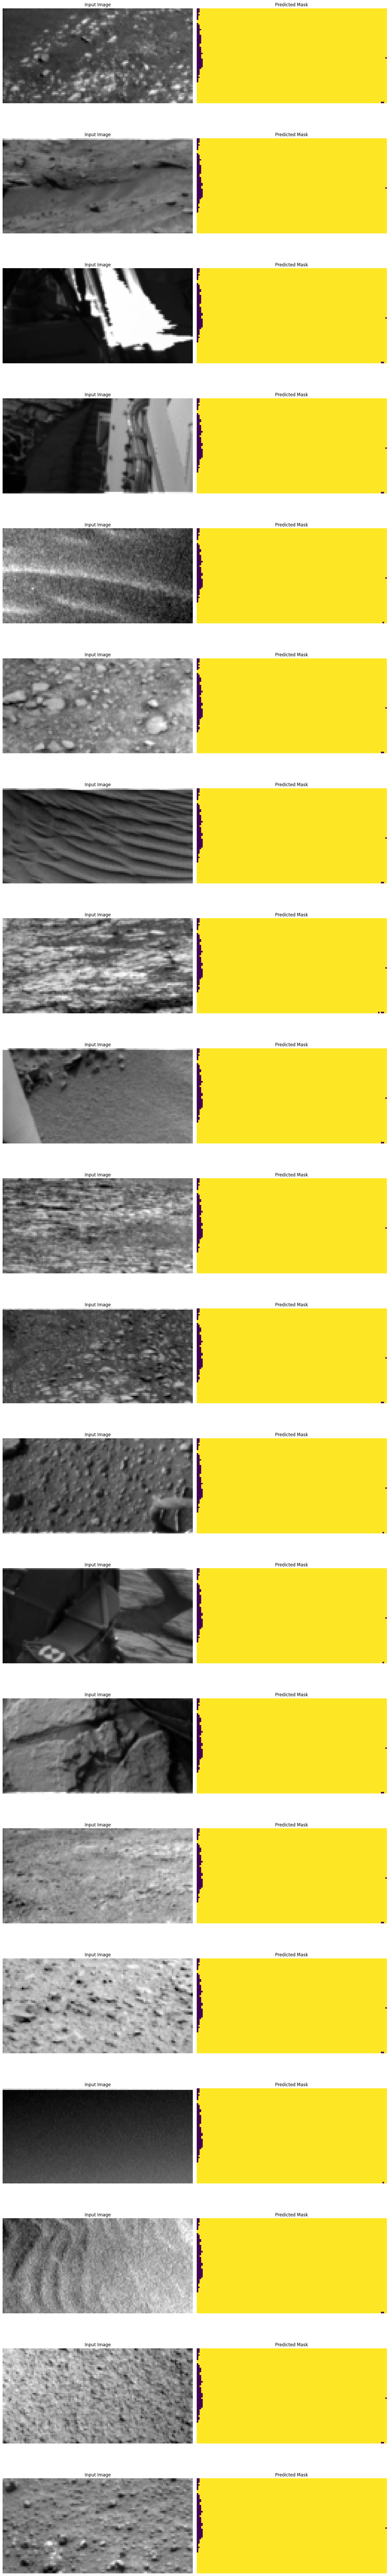

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [23]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [37]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
len(submission_df.columns)

In [ ]:
len(submission_df)